# FCI or PC with the PMIME measure

**PMIME: Partial Mutual Information from Mixed Embedding  (D. Kugiumtzis, 2013)**

PMIME is an asymmetric and non-parametric measure designed to detect direct couplings in time series. It is derived from an embedding scheme based on a selection criterion, the conditional mutual information. In the multivariate case, to assess whether a variable $X$ leads a variable $Y$, conditional on a set of variables $Z=\{Z^0,Z^1,\dots,Z^{g-2}\}$, it builds iteratively an embedding vector $\textbf{w}$ from the lagged components extracted from $(X,Y,Z)$ that explains the best the future of $Y$, noted $Y_t^T = (Y_{t+1},...,Y_{t+T})$. Each iteration is called an embedding cycle and uses a stopping criterion to accept or reject a component. A component is accepted if the information it brings strictly increases the information already contained in the embedding vector.

Hence $\textbf w$ is formed from $k$ lagged variables, selected by the Conditional Mutual Information (CMI) and can be decomposed as $\textbf w_t = (w_t^x,w_t^y,w_t^Z)$, where $w_t^x$ are the components of $X$ selected in the process, $w_t^y$ those from $Y$ and all the remaining ones are denoted as $w_t^Z$.\\ We then quantify the causal effect from $X$ to $Y$, conditional on $Z$ by : $$R_{X\rightarrow Y |Z} = \dfrac{I(Y_t^T,\textbf w_t^x|\textbf w_t^y,\textbf w_t^Z)}{I(Y_t^T;\textbf w_t)}.$$

The embedding process alone could be a measure of causality. Indeed, if $w_t^x$ is empty, it means that $X$ has no influence on $Y$, which translates in the measure $R$: if $w_t^X$ is empty, then $R$ equals $0$. Furthermore, this measure is bounded between $0$ and $1$, $0$ means independence and $1$ means that the future of $Y$ is totally driven by $X$.

**Imports**

In [30]:
import run_alg
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

The code contains PC algorithm and FCI algorithms. The base of both algorithms is taken from C. K. Assaad (https://github.com/ckassaad/). The difference is here the Conditional Independence metric used is the PMIME.

To run the code just use the ``run_algo()`` function, with params:
* ``data``: a pandas dataframe containing d time series of length n
+ ``nlags``: integer, the maximal lag considered
+ ``p_value, rank_using_p_value``: set on Faulse for use with PMIME (parameters from the old code)
+ ``verbose``: bool, display info or not
+ ``nb_process``: int, number of processors involved in the parallelization
+ ``sig_pmime``: float, threshold of the stopping criterion in the building of the embedding vector of PMIME
+ ``knnei``: float, parameter to adjust the number of nearest neighbors in the knn estimation of the CMI in PMIME
+ ``bootstrap``: bool, True if the building of the embedding vector done with bootstrap estimation of the null and not with a fixed threshold
+ ``sig_bs``: float, statistical significance threshold in the bootstrap procedure
+ ``nb_bs``: number of bootstrap iterations

The function ``run_algo()`` outputs three summary causal graphs ``g, og, sg`` from the ``networkx.Digraph`` class.
* ``g``: oriented graph with auto-causation (or self-cause) represented
+ ``og``: oriented graph without self-cause
+ ``sg``: only self-causes without the links between the variables

### Toy example

Consider the following multivariate process $\mathbf X = (X^0,X^1,X^2,X^3)$ of size $n$, such that:\
$X^0_t = \alpha_0 X^0_{t-1} + 0.01\varepsilon^0_t$\
$X^1_t = \alpha_1 X^1_{t-1} + \beta_1 \tanh(X^0_{t-3})+ \gamma^1_t \sin(X^1_{t-2}) + 0.01\varepsilon^1_t$\
$X^2_t = \alpha_2 X^2_{t-1} + \beta_2 abs(X^3_{t-1}) + 0.01\varepsilon^2_t$\
$X^3_t = \alpha_4 X^3_{t-1} + 0.01 \varepsilon^3_t$

with $\alpha_i \sim \mathcal U(a,b)~ a,b>0 \;$ and $(\varepsilon^i_t)_{t=1,...n}$ are iid $\sim \mathcal N(0,\sigma^2)$, $i=0,...,3$. 

In the following, the size of the time series simulated is $n = 2000$. The graph simulated is shown below.

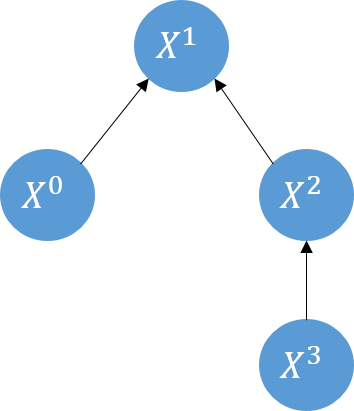

In [35]:
from IPython.display import Image

Image(filename='simulated_graph.png')

In [33]:
n = 2000
X=1/10*np.ones((n,4))
X[1,1] = np.random.randn()

def noise(std):
    return 0.1*np.random.normal(loc = 0, scale = std)

def coef(low, high =1):
    return np.random.uniform(low = low, high = 1)

for j in range(1,n):
    X[j,0] = coef(0.4)*X[j-1,0] + noise(4)
for k in range(1,n):
    X[k,3] = coef(0.5)*X[k-1,3] + noise(3)
for k in range(1,n):
    X[k,2] = coef(0.4)*np.abs(X[k-1,3]) + coef(0.7) *X[k-1,2] + noise(1)
for t in range(2,n):
    X[t,1] = coef(0.8)*np.tanh(X[t-3,0])  + coef(0.3)*np.sin(X[t-2,2]) +  coef(0.6)*X[t-1,1] + noise(5)
    
df = pd.DataFrame(data = X, columns = ['$X^0$','$X^1$','$X^2$','$X^3$'])

One can use tigramite library (https://github.com/jakobrunge/tigramite) to display the time series and make a first analysis.

In [20]:
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

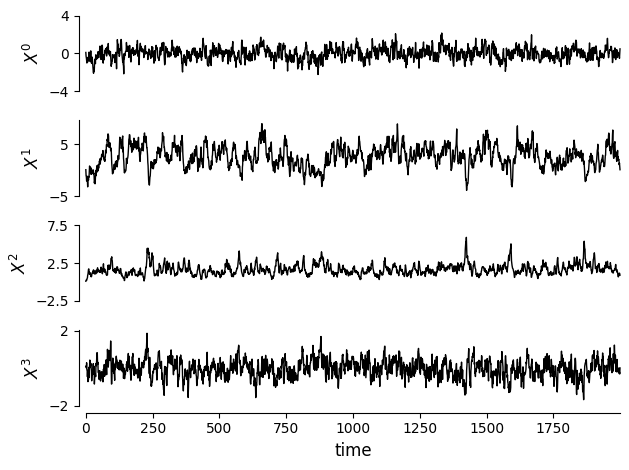

In [27]:
dataframe = pp.DataFrame(data = X, var_names =['$X^0$','$X^1$','$X^2$','$X^3$'] )
tp.plot_timeseries(dataframe)
plt.show()

Display the correlations map using the Partial Correlation function from tigramite:

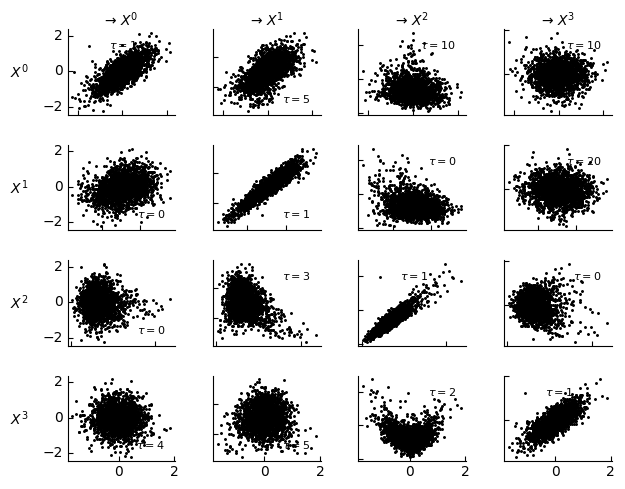

In [36]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']

scatter_lags = np.argmax(np.abs(correlations), axis=2)
tp.plot_scatterplots(dataframe=dataframe, add_scatterplot_args={'scatter_lags':scatter_lags}); plt.show()

Then run the PC algorithm (or FCI) with the ``run_algo()`` function. Here the PC algorithm is run, to use FCI change the method to 'FCI'.

In [34]:
g, og, sg = run_alg.run_algo(df, method = 'PC', nb_process = 10, knnei = 0.01, sig_pmime = 0.03)

n: 2000
d: 4
names: Index(['$X^0$', '$X^1$', '$X^2$', '$X^3$'], dtype='object')
sampling_rate: {'$X^0$_t-': 1, '$X^0$_t': 1, '$X^1$_t-': 1, '$X^1$_t': 1, '$X^2$_t-': 1, '$X^2$_t': 1, '$X^3$_t-': 1, '$X^3$_t': 1}
threshold pmime: 0.03
#######################################
########### Starting PC ###########
########### 15:41:21 ###########
#######################################
######################################
Skeleton Initialization
######################################


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:02<00:00, 10.62it/s]


 for x= $X^2$_t  and y = $X^3$_t R =  -1.05402516766609e-15

 for x= $X^1$_t  and y = $X^3$_t R =  -1.05402516766609e-15

 for x= $X^1$_t  and y = $X^2$_t R =  -4.687409048886246e-16

 for x= $X^0$_t  and y = $X^2$_t R =  -4.687409048886246e-16



 for x= $X^0$_t  and y = $X^3$_t R =  -1.05402516766609e-15

 for x= $X^0$_t-5  and y = $X^3$_t R =  -1.05402516766609e-15

 for x= $X^0$_t-5  and y = $X^2$_t R =  -4.687409048886246e-16
no conditioning set

 for x= $X^0$_t-5  and y = $X^0$_t R =  1.0

 for x= $X^0$_t  and y = $X^1$_t R =  -5.140843881323183e-16

 for x= $X^1$_t-5  and y = $X^2$_t R =  -4.687409048886246e-16
no conditioning set

 for x= $X^2$_t-5  and y = $X^2$_t R =  1.0

 for x= $X^1$_t-5  and y = $X^3$_t R =  0.04593786129029602

 for x= $X^2$_t-5  and y = $X^0$_t R =  -1.2577937190366198e-15

 for x= $X^2$_t-5  and y = $X^3$_t R =  -1.05402516766609e-15

 for x= $X^1$_t-5  and y = $X^0$_t R =  0.030613411449780744
no conditioning set

 for x= $X^1$_t-5  and y = $X^1$_t R =  1.0
no conditioning set

 for x= $X^3$_t-5  and y = $X^3$_t R =  1.0

 for x= $X^0$_t-5  and y = $X^1$_t R =  0.12833212369097644

 for x= $X^3$_t-5  and y = $X^2$_t R =  0.20679461244027816

 for x= $X^3$_t-5  and y = $X^0$_t R =  0.0593869580

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]

 _cmi_sep_set_pq _cmi_sep_set_pq
node p $X^0$_t-  node q $X^1$_t  cond z dict_keys(['$X^2$_t-'])

node p $X^0$_t-  node q $X^0$_t  cond z dict_keys(['$X^1$_t-'])
node p $X^0$_t-  node q $X^0$_t  cond z dict_keys(['$X^3$_t-'])
 _cmi_sep_set_pq
node p $X^1$_t-  node q $X^0$_t  cond z dict_keys(['$X^0$_t-'])
 _cmi_sep_set_pq
node p $X^1$_t-  node q $X^1$_t  cond z dict_keys(['$X^2$_t-'])
node p $X^1$_t-  node q $X^1$_t  cond z dict_keys(['$X^0$_t-'])
 _cmi_sep_set_pq
node p $X^1$_t-  node q $X^3$_t  cond z dict_keys(['$X^3$_t-'])
 _cmi_sep_set_pq
node p $X^2$_t-  node q $X^1$_t  cond z dict_keys(['$X^0$_t-'])
 _cmi_sep_set_pq
node p $X^2$_t-  node q $X^2$_t  cond z dict_keys(['$X^3$_t-'])
 _cmi_sep_set_pq
node p $X^3$_t-  node q $X^0$_t  cond z dict_keys(['$X^0$_t-'])
 _cmi_sep_set_pq
node p $X^3$_t-  node q $X^2$_t  cond z dict_keys(['$X^2$_t-'])
 _cmi_sep_set_pq
node p $X^3$_t-  node q $X^3$_t  cond z dict_keys(['$X^1$_t-'])



 for x= $X^3$_t-5  and y = $X^2$_t conditioning on z= dict_keys(['$X^2$_t-']) R =  0.20679461244027816

 for x= $X^1$_t-5  and y = $X^3$_t conditioning on z= dict_keys(['$X^3$_t-']) R =  0.04593786129029602

 for x= $X^3$_t-5  and y = $X^0$_t conditioning on z= dict_keys(['$X^0$_t-']) R =  0.059386958088007515
node p $X^3$_t-  node q $X^0$_t  cond z dict_keys(['$X^1$_t-'])

 for x= $X^1$_t-5  and y = $X^0$_t conditioning on z= dict_keys(['$X^0$_t-']) R =  0.030613411449780744
node p $X^1$_t-  node q $X^0$_t  cond z dict_keys(['$X^3$_t-'])

 for x= $X^3$_t-5  and y = $X^0$_t conditioning on z= dict_keys(['$X^1$_t-']) R =  0.059386958088007515

 for x= $X^1$_t-5  and y = $X^0$_t conditioning on z= dict_keys(['$X^3$_t-']) R =  -1.2362148333606028e-15

 for x= $X^0$_t-5  and y = $X^1$_t conditioning on z= dict_keys(['$X^2$_t-']) R =  0.1797890542521064
node p $X^0$_t-  node q $X^1$_t  cond z dict_keys(['$X^1$_t-'])

 for x= $X^2$_t-5  and y = $X^1$_t conditioning on z= dict_keys(['$X^0$_t

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3004.52it/s]

 _cmi_sep_set_pq
node p $X^0$_t-  node q $X^1$_t  cond z dict_keys(['$X^2$_t-', '$X^1$_t-'])
 _cmi_sep_set_pq
node p $X^1$_t-  node q $X^1$_t  cond z dict_keys(['$X^2$_t-', '$X^0$_t-'])
 _cmi_sep_set_pq
node p $X^2$_t-  node q $X^1$_t  cond z dict_keys(['$X^0$_t-', '$X^1$_t-'])



 for x= $X^2$_t-5  and y = $X^1$_t conditioning on z= dict_keys(['$X^0$_t-', '$X^1$_t-']) R =  0.05354000883459771

 for x= $X^0$_t-5  and y = $X^1$_t conditioning on z= dict_keys(['$X^2$_t-', '$X^1$_t-']) R =  0.1797890542521064
p=$X^2$_t-; q=$X^1$_t; r=['$X^0$_t-', '$X^1$_t-']; I(p,q|r)= 0.05354; I(p,q)= 0.03515 
p=$X^0$_t-; q=$X^1$_t; r=['$X^2$_t-', '$X^1$_t-']; I(p,q|r)= 0.17979; I(p,q)= 0.12833 
p=$X^1$_t-; q=$X^1$_t; r=['$X^2$_t-', '$X^0$_t-']; I(p,q|r)= 1.00000; I(p,q)= 1.00000 
set_size 3


0it [00:00, ?it/s]


set_size 4


0it [00:00, ?it/s]


set_size 5


0it [00:00, ?it/s]


set_size 6


0it [00:00, ?it/s]

######################################
Rule Origin of Causality
######################################
######################################
Final Results (PC)
######################################
Extended Summary Graph:
[('$X^0$_t-', '$X^0$_t'), ('$X^0$_t-', '$X^1$_t'), ('$X^1$_t-', '$X^1$_t'), ('$X^1$_t-', '$X^3$_t'), ('$X^2$_t-', '$X^1$_t'), ('$X^2$_t-', '$X^2$_t'), ('$X^3$_t-', '$X^0$_t'), ('$X^3$_t-', '$X^2$_t'), ('$X^3$_t-', '$X^3$_t')]
[('$X^0$', '$X^0$'), ('$X^0$', '$X^1$'), ('$X^1$', '$X^1$'), ('$X^1$', '$X^3$'), ('$X^2$', '$X^1$'), ('$X^2$', '$X^2$'), ('$X^3$', '$X^0$'), ('$X^3$', '$X^2$'), ('$X^3$', '$X^3$')]
[('$X^0$', '$X^0$'), ('$X^0$', '$X^1$'), ('$X^1$', '$X^1$'), ('$X^1$', '$X^3$'), ('$X^2$', '$X^1$'), ('$X^2$', '$X^2$'), ('$X^3$', '$X^0$'), ('$X^3$', '$X^2$'), ('$X^3$', '$X^3$')]
[('$X^0$', '$X^1$'), ('$X^1$', '$X^3$'), ('$X^2$', '$X^1$'), ('$X^3$', '$X^0$'), ('$X^3$', '$X^2$')]
[('$X^0$', '$X^0$'), ('$X^1$', '$X^1$'), ('$X^2$', '$X^2$'), ('$X^3$', '$X^3$')]


Once the causal discovery algorithm has stoped, display the causal graph obtained with the ``networkx`` library for instance:

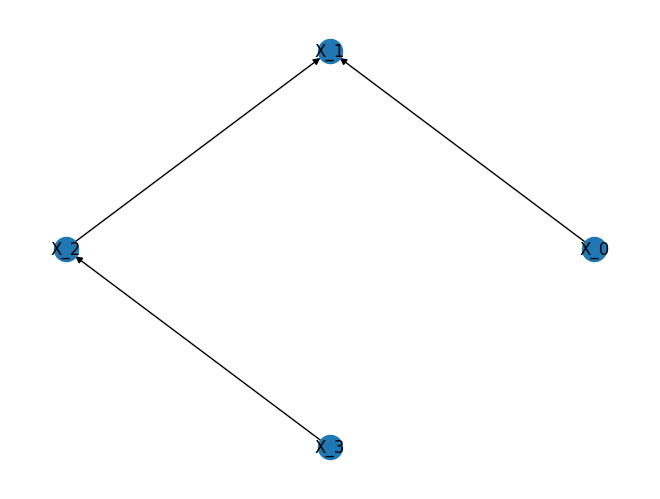

In [32]:
nx.draw_circular(og, with_labels = True)

Here the graph infered is the same as the simulated graph.